In [1]:
!pip install gymnasium
!pip install git+https://github.com/arnavg115/agrad.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.5 MB/s eta 0:00:00
  Cloning https://github.com/arnavg115/agrad.git to /tmp/pip-req-build-94451rx9
  Running command git clone --filter=blob:none --quiet https://github.com/arnavg115/agrad.git /tmp/pip-req-build-94451rx9
  Resolved https://github.com/arnavg115/agrad.git to commit 32cb2324412af66b0bb134158de74fd9d5360d55
  Preparing metadata (setup.py) ... done
  Created wheel for agrad: filename=agrad-1.1.0-py3-none-any.whl size=8338 sha256=48c541fd13433f3f9e5fbd3048a2c39721dc26c38125aee77e1f6e87134bc365
  Stored in directory: /tmp/pip-ephem-wheel-cache-v07_p799/wheels/42/01/36/b8d00f76dd88c9798574520ee5b4284434c4db7b708c5a1c20
Successfully built agrad


In [2]:
import gymnasium as gym

env = gym.make("CartPole-v1")

In [3]:
import agrad.nn as nn
from agrad.nn import optimizer
import agrad.functional as F
import numpy as np
import agrad as ag
from collections import deque

In [4]:
class mlp(nn.Module):
  def __init__(self, obs, actions):
    self.l1 = nn.Linear(obs, 256)
    self.l2 = nn.Linear(256, actions)
    self.n_actions = actions

  def forward(self, x):
    return F.softmax(self.l2(F.relu(self.l1(x))))

  def action(self, obs):
    y = self.forward(obs).reshape((self.n_actions,))
    action = np.random.choice(np.arange(self.n_actions), p=y.data)
    lp = F.log(y)[action]
    return action, lp

In [13]:
gamma = 0.9
ne = mlp(env.observation_space.shape[0], env.action_space.n)
optim = optimizer.adam(lr=1e-3)

rolling = deque(maxlen=100)
out = []

for ep in range(1000):

  obs, _ = env.reset()
  rewards = []
  log_probs = []
  done = False

  while not done:
    ob = ag.Tensor(obs).reshape((1,-1))
    action, lp = ne.action(ob)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    log_probs.append(lp)

    done = terminated or truncated

    obs = new_obs
  if ep % 100 == 0:
    out += list(rolling)
    print(f"Ep: {ep}, sum_rew: {sum(rolling)/ 100}")
  rolling.append(sum(rewards))

  ds_r = []
  Gt = 0
  for r in reversed(rewards):
    Gt = reward + gamma * Gt
    ds_r.insert(0, Gt)

  ds_r = ag.Tensor(np.array(ds_r))
  ds_r = (ds_r - ds_r.data.mean()) / ds_r.data.std()
  lps = ag.stack(log_probs)
  pg = (-lps * ds_r).sum()

  ne.zero_grad()
  pg.backward()
  optim.step(ne)

Ep: 0, sum_rew: 0.0
Ep: 100, sum_rew: 34.46
Ep: 200, sum_rew: 103.57
Ep: 300, sum_rew: 234.47
Ep: 400, sum_rew: 292.87
Ep: 500, sum_rew: 276.97
Ep: 600, sum_rew: 292.6
Ep: 700, sum_rew: 164.1
Ep: 800, sum_rew: 169.31
Ep: 900, sum_rew: 130.94


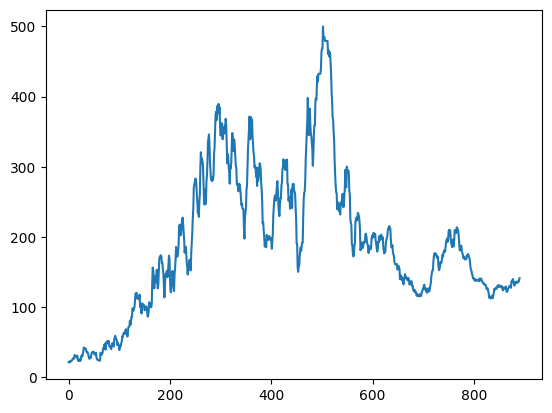

In [15]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 10

smoothed_data = moving_average(out, window_size)
plt.plot(smoothed_data)

In [7]:
# https://stackoverflow.com/questions/77042526/how-to-record-and-save-video-of-gym-environment
import gymnasium as gym

###
# create a temporary variable with our env, which will use rgb_array as render mode. This mode is supported by the RecordVideo-Wrapper
tmp_env = gym.make("CartPole-v1", render_mode="rgb_array")

# wrap the env in the record video
env = gym.wrappers.RecordVideo(env=tmp_env,video_folder="/content/sample_data",name_prefix="test-video", episode_trigger=lambda x: x % 1 == 0)

# env reset for a fresh start
obs, info = env.reset()

###
# Start the recorder


# AI logic
for _ in range(500):
    # action = env.action_space.sample()  # agent policy that uses the observation and info
    ob = ag.Tensor(obs).reshape((1, -1))
    action, _ = ne.action(ob)
    obs, reward, terminated, truncated, _ = env.step(action)

    env.render()

    if terminated or truncated:
        observation, info = env.reset()


# Close the environment
env.close()


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/sample_data folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [9]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/sample_data/test-video-episode-1.mp4"

# Compressed video path
compressed_path = "/content/videos/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [10]:
class baseline(nn.Module):
  def __init__(self, obs):
    self.l1 = nn.Linear(obs, 128)
    self.l2 = nn.Linear(128, 1)

  def forward(self, x):
    return self.l2(F.relu(self.l1(x)))

In [11]:
gamma = 0.99
ne = mlp(env.observation_space.shape[0], env.action_space.n)
bl = baseline(env.observation_space.shape[0])


optim = optimizer.adam(lr = 1e-3)
b_optim = optimizer.adam(lr = 1e-2)
rolling = deque(maxlen=100)
out = []
criterion = nn.MSE()

for ep in range(1000):

  obs, _ = env.reset()
  rewards = []
  states = []
  log_probs = []
  done = False

  while not done:
    ob = ag.Tensor(obs).reshape((1, -1))
    action, lp = ne.action(ob)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    rewards.append(reward)
    log_probs.append(lp)
    states.append(obs)

    done = terminated or truncated

    obs = new_obs
  if ep % 100 == 0:
    out += list(rolling)
    print(f"Ep: {ep}, sum_rew: {sum(rolling)/ 100}")
  rolling.append(sum(rewards))

  ds_r = []

  for j in range(len(rewards)):
    pw = 0
    Gt = 0
    for r in rewards[j:]:
      Gt += gamma ** pw * r
      pw +=1
    ds_r.append(Gt)

  obss = ag.Tensor(np.stack(states))
  ds_r = ag.Tensor(np.array(ds_r)).reshape((-1, 1))
  vals = bl(obss)

  # loss = F.mse_loss(vals, ds_r.detach())
  loss = criterion(vals, ds_r.detach(), "mean")


  ds_r = ds_r - vals.detach()
  lps = ag.stack(log_probs)
  pg = (-lps * ds_r).sum()

  ne.zero_grad()
  pg.backward()
  optim.step(ne)

  bl.zero_grad()
  loss.backward()
  b_optim.step(bl)


Ep: 0, sum_rew: 0.0
Ep: 100, sum_rew: 33.91
Ep: 200, sum_rew: 65.03
Ep: 300, sum_rew: 134.16
Ep: 400, sum_rew: 281.1
Ep: 500, sum_rew: 313.59
Ep: 600, sum_rew: 384.8
Ep: 700, sum_rew: 340.38
Ep: 800, sum_rew: 419.18
Ep: 900, sum_rew: 413.66


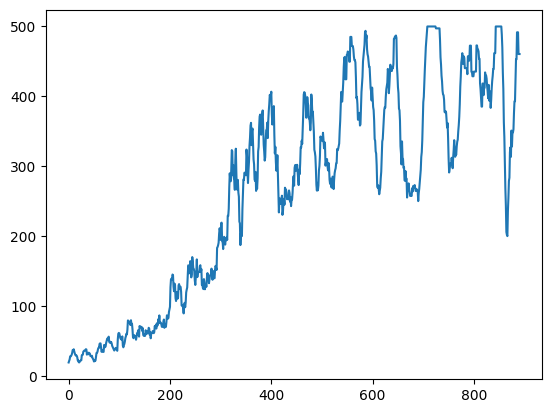

In [12]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 10

smoothed_data = moving_average(out, window_size)
plt.plot(smoothed_data)